In [1]:
import httpx
import zipfile
import io
import pandas

data_src = "https://github.com/sgc-kn/cds-examples/raw/refs/heads/main/sis-ecde-climate-indicators.zip"

response = httpx.get(data_src, follow_redirects=True)

reanalysis = {
    "Extremniederschlagstage_Anzahl": "15_frequency_of_extreme_precipitation-reanalysis-yearly-grid-1940-2023-v1.0-data.csv",
    "Frosttage_Anzahl": "11_frost_days-reanalysis-yearly-grid-1940-2023-v1.0-t2m.csv",
    "Heisse_Tage_Anzahl": "06_hot_days-reanalysis-yearly-30deg-grid-1940-2023-v1.0-t2m.csv",
    "Tropennaechte_Anzahl": "05_tropical_nights-reanalysis-yearly-grid-1940-2023-v1.0-t2m.csv",
    "Hitzewellentage_Anzahl": "09_heat_waves_climatological-reanalysis-yearly-grid-1940-2023-v1.0-data.csv",
}

rcp_4_5 = {
    "Extremniederschlagstage_Anzahl": "15_frequency_of_extreme_precipitation-projections-yearly-rcp_4_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-data.csv",
    "Frosttage_Anzahl": "11_frost_days-projections-yearly-rcp_4_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-tasAdjust_NON_CDM.csv",
    "Heisse_Tage_Anzahl": "06_hot_days-projections-yearly-30deg-rcp_4_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-tasAdjust_NON_CDM.csv",
    "Tropennaechte_Anzahl": "05_tropical_nights-projections-yearly-rcp_4_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-tasAdjust_NON_CDM.csv",
    "Hitzewellentage_Anzahl": "09_heat_waves_climatological-projections-yearly-rcp_4_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-data.csv",
}

rcp_8_5 = {
    "Extremniederschlagstage_Anzahl": "15_frequency_of_extreme_precipitation-projections-yearly-rcp_8_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-data.csv",
    "Frosttage_Anzahl": "11_frost_days-projections-yearly-rcp_8_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-tasAdjust_NON_CDM.csv",
    "Heisse_Tage_Anzahl": "06_hot_days-projections-yearly-30deg-rcp_8_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-tasAdjust_NON_CDM.csv",
    "Tropennaechte_Anzahl": "05_tropical_nights-projections-yearly-rcp_8_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-tasAdjust_NON_CDM.csv",
    "Hitzewellentage_Anzahl": "09_heat_waves_climatological-projections-yearly-rcp_8_5-cclm4_8_17-mpi_esm_lr-r1i1p1-grid-v1.0-data.csv",
}


def read_columns(zf, columns):
    acc = dict()
    for key, csv_name in columns.items():
        df = pandas.read_csv(zf.open(csv_name))
        df["Jahr"] = pandas.to_datetime(df.date).dt.year
        df = df.set_index("Jahr")
        acc[key] = df.konstanz
    return acc


with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    reanalysis = pandas.DataFrame(read_columns(zf, reanalysis))
    rcp_4_5 = pandas.DataFrame(read_columns(zf, rcp_4_5))
    rcp_8_5 = pandas.DataFrame(read_columns(zf, rcp_8_5))

In [2]:
combined = pandas.concat(
    [
        reanalysis.assign(Modell="Reanalyse"),
        rcp_4_5.assign(Modell="Projektion RCP 4,5"),
        rcp_8_5.assign(Modell="Projektion RCP 8,5"),
    ]
)

In [3]:
combined

,Extremniederschlagstage_Anzahl,Frosttage_Anzahl,Heisse_Tage_Anzahl,Tropennaechte_Anzahl,Hitzewellentage_Anzahl,Modell
Jahr,,,,,,
1940,5,111,0,0,0,Reanalyse
1941,7,121,0,1,0,Reanalyse
1942,7,116,0,0,0,Reanalyse
1943,6,107,4,2,0,Reanalyse
1944,7,122,0,4,0,Reanalyse
...,...,...,...,...,...,...
2096,9,17,56,59,39,"Projektion RCP 8,5"
2097,15,19,18,34,8,"Projektion RCP 8,5"
2098,7,18,42,52,15,"Projektion RCP 8,5"


In [4]:
numeric_columns = combined.columns.difference(["Modell"])

quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Compute moving quantiles for each model separately
result = []
for model, group in combined.sort_index().groupby("Modell"):
    for quantile in quantiles:
        rolling_quantiles = (
            group[numeric_columns]
            .rolling(window=30, center=True)
            .quantile(quantile, interpolation="linear")
            .dropna()
        )
        rolling_quantiles["Modell"] = model
        rolling_quantiles["Quantil"] = str(quantile)
        result.append(rolling_quantiles)

# Combine results into a single DataFrame
quantiles = pandas.concat(result)
quantiles

,Extremniederschlagstage_Anzahl,Frosttage_Anzahl,Heisse_Tage_Anzahl,Hitzewellentage_Anzahl,Tropennaechte_Anzahl,Modell,Quantil
Jahr,,,,,,,
1965,3.45,50.3,0.0,0.00,0.00,"Projektion RCP 4,5",0.05
1966,3.45,41.8,0.0,0.00,0.00,"Projektion RCP 4,5",0.05
1967,3.45,41.8,0.0,0.00,0.00,"Projektion RCP 4,5",0.05
1968,3.45,41.8,0.0,0.00,0.00,"Projektion RCP 4,5",0.05
1969,3.45,41.8,0.0,0.00,0.00,"Projektion RCP 4,5",0.05
...,...,...,...,...,...,...,...
2005,13.55,87.2,13.2,5.20,15.65,Reanalyse,0.95
2006,13.55,87.2,13.2,5.20,15.65,Reanalyse,0.95
2007,14.55,87.2,13.2,5.20,15.65,Reanalyse,0.95


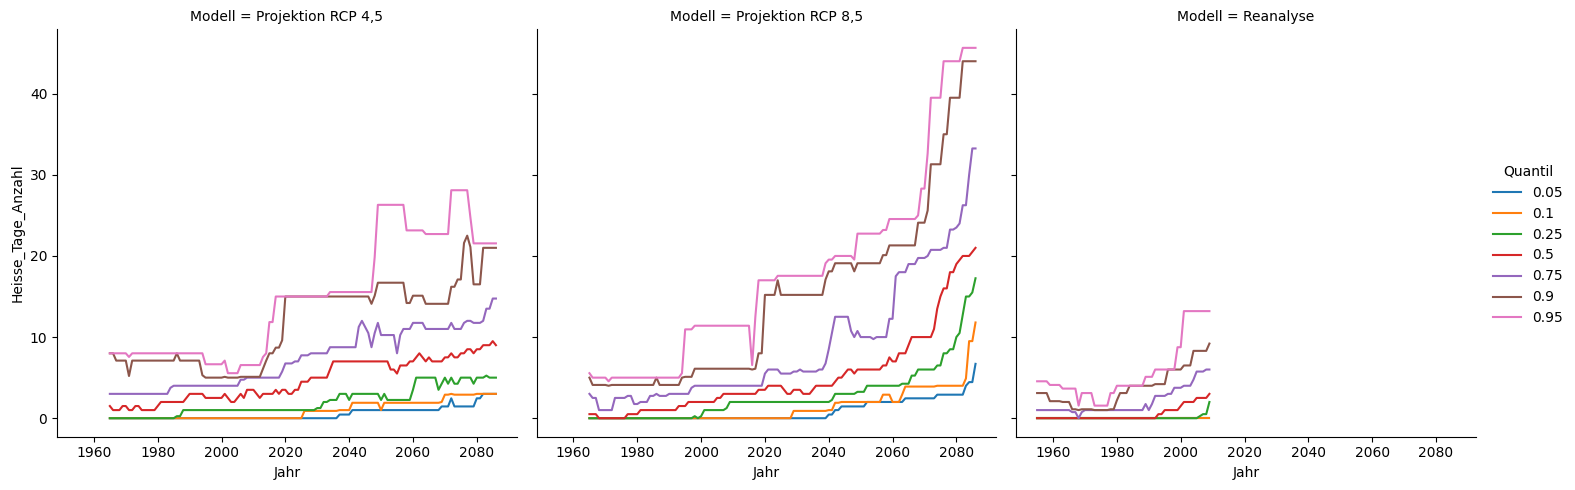

In [5]:
import seaborn

seaborn.relplot(
    kind="line",
    data=quantiles,
    x="Jahr",
    y="Heisse_Tage_Anzahl",
    col="Modell",
    hue="Quantil",
)

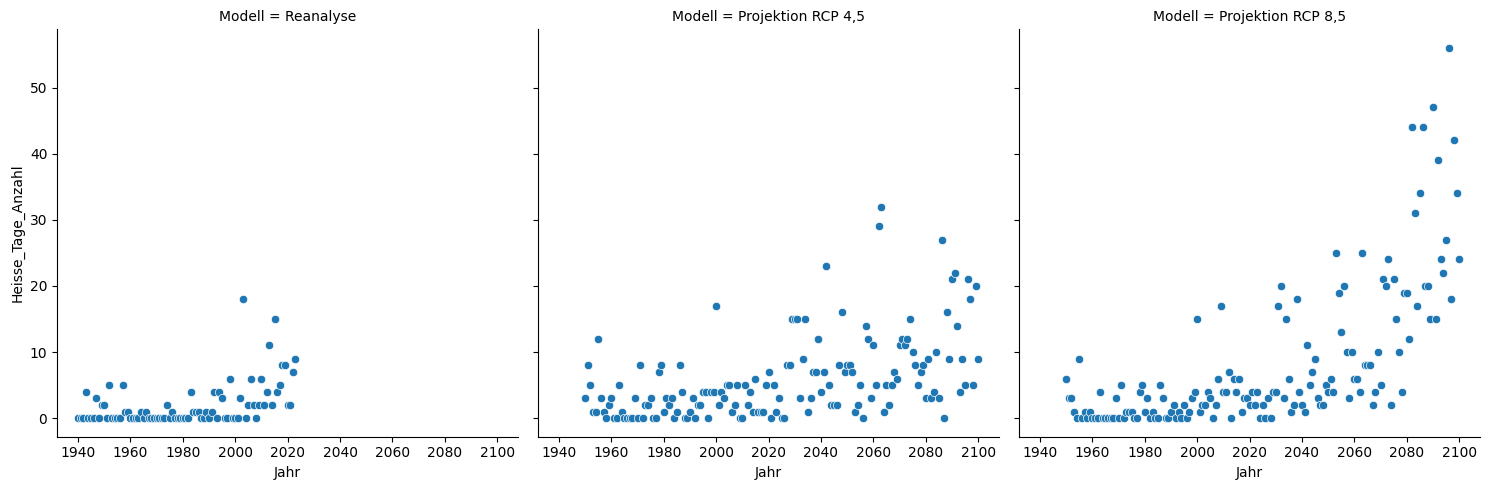

In [6]:
import seaborn

seaborn.relplot(
    data=combined,
    x="Jahr",
    y="Heisse_Tage_Anzahl",
    col="Modell",
)